In [38]:
import os, sys, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, recall_score

import mxnet as mx
from mxnet import gluon, autograd

In [9]:
df_train = pd.read_csv('data/train_embed.csv')
df_val = pd.read_csv('data/val_embed.csv')

In [12]:
N_trees = 32 # Number of columns
N_leaves = 500 # Number of distinct values
target = 'isFraud'
features = df_train.columns.tolist()
features.remove(target)

In [103]:
train_dataset = gluon.data.SimpleDataset(list(zip(
    df_train[features].values.tolist(),
    df_train[target].values.astype('int32'))))

val_dataset = gluon.data.SimpleDataset(list(zip(
    df_val[features].values.tolist(),
    df_val[target].values.astype('int32'))))

In [104]:
bs = 512
ctx = [mx.gpu(7)]

In [105]:
train_data = gluon.data.DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=0,
)

val_data = gluon.data.DataLoader(
    dataset=val_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=0,
)

In [133]:
for x, y in train_data:
    break

In [134]:
x.dtype

numpy.int64

In [135]:
y.dtype

numpy.int32

In [230]:
def calculate_recall_at_fpr(y_true, y_hat, fpr_target=0.04):
        fpr, tpr, thresholds = roc_curve(y_true, y_hat)
        fpr_idx = max(np.where(fpr<=fpr_target)[0])
        thresh = thresholds[fpr_idx]

        return recall_score(y_true, y_hat>thresh)


def evaluate_network(network, data_iterator, ctx):
    loss_acc = 0.
    loss = gluon.loss.SigmoidBCELoss()

    y_trues = list()
    y_hats = list()

    for idx, (X, y) in enumerate(data_iterator):
        X_ = gluon.utils.split_and_load(X, ctx)
        y_ = gluon.utils.split_and_load(y, ctx)

        #print(len(y_))
        preds = [network(x) for x in X_]
        print(preds[0].shape)
        print(y_[0].shape)
        losses = [loss(p, y).asnumpy() for p, y in zip(preds, y_)]
        
        loss_acc += sum(losses).mean() / len(ctx) 

        y_trues += [y_i.asnumpy() for y_i in y_]
        y_hats += [p.asnumpy().flatten() for p in preds]

    y_true = np.concatenate(y_trues)
    y_hat = np.concatenate(y_hats)

    auc = roc_auc_score(y_true, y_hat)
    recall = calculate_recall_at_fpr(y_true, y_hat)

    return loss_acc / float(idx + 1), auc, recall


def train(network, train_data, holdout_data, epochs, ctx, 
          lr=1e-3, wd=1e-5, optimizer='adam', trainer_fp='./models/example.trainer'):

        np.random.seed(123)
        mx.random.seed(123)

        trainer = gluon.Trainer(network.collect_params(), optimizer,
                                {'learning_rate': lr, 'wd': wd})

        if os.path.exists(trainer_fp):
            trainer.load_states(trainer_fp)

        loss = gluon.loss.SigmoidBCELoss()

        network.hybridize()

        losses_output = []

        dev_loss, auc, recall = evaluate_network(network, holdout_data, ctx)

        print("Baseline: Dev AUC {:.4f}, Recall@0.04 FPR {:.4f}".format(auc, recall))

        for e in range(epochs):
            loss_acc = 0.
            for idx, (X, y) in enumerate(train_data):
                X_ = gluon.utils.split_and_load(X, ctx)
                y_ = gluon.utils.split_and_load(y, ctx)

                with autograd.record():
                    preds = [network(x) for x in X_]
                    losses = [loss(p, y) for p, y in zip(preds, y_)]

                [l.backward() for l in losses]

                loss_acc += sum([l.asnumpy().mean() for l in losses]) / len(ctx)
                trainer.step(X.shape[0])

            dev_loss, auc, recall = evaluate_network(network, holdout_data, ctx)
            train_loss = loss_acc / float(idx + 1)

            print(
                "Epoch [{}], Training BCE {:.4f}, Dev AUC {:.4f}, Dev Recall@0.04 FPR {:.4f}".format(
                    e + 1, train_loss, auc, recall)
            )
            losses_output.append((train_loss, dev_loss))

        trainer.save_states(trainer_fp)
        return losses_output


In [231]:
class TransactionEmbed(gluon.nn.HybridBlock):
    def __init__(self, n_cols, n_unique, embed_dim, dropout=0.0):
        super(TransactionEmbed, self).__init__(prefix='TransactionEmbed_')

        self.dropout_ = dropout
        self.embeddings = list()
        
        with self.name_scope():
            for col_idx in range(n_cols):
                embedding = gluon.nn.Embedding(
                    input_dim=n_unique,
                    output_dim=embed_dim,
                    prefix='%d_embed_' % col_idx,
                )
                self.embeddings.append(embedding)
                self.register_child(embedding)

            if self.dropout_:
                self.dropout = gluon.nn.Dropout(self.dropout_, prefix='dropout_')
                
            self.out_node = gluon.nn.Dense(1)


    def hybrid_forward(self, F, X):
        embeds = list()
        for i, embedding in enumerate(self.embeddings):            
            embeds.append(embedding(F.slice_axis(X, axis=1, begin=i, end=i+1)))
        
        net = F.concat(*embeds, dim=2)
        if self.dropout_:
            net = self.dropout(net)

        return self.out_node(F.flatten(net.relu()))

In [232]:
# net = gluon.nn.HybridSequential()
# net.add(TransactionEmbed(N_trees, N_leaves, 5))
# net.add(gluon.nn.Dense(1))
net = TransactionEmbed(N_trees, N_leaves, 5)

In [233]:
net.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

In [234]:
net.hybridize()

In [235]:
x.as_in_context(ctx[0]).shape

(512L, 32L)

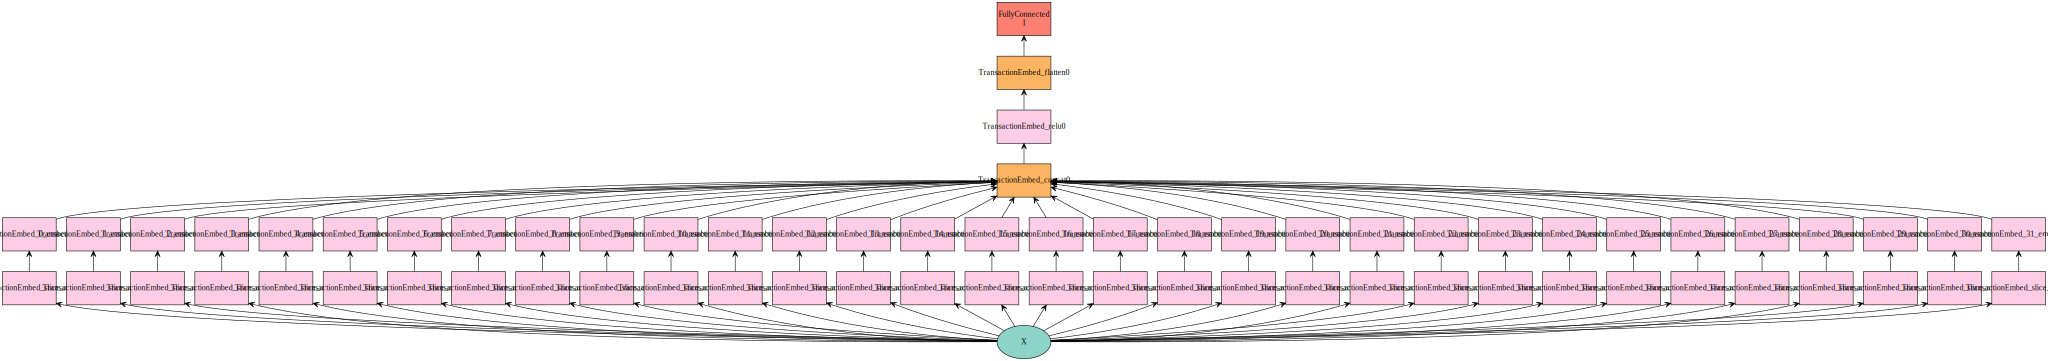

In [236]:
mx.viz.plot_network(net(mx.sym.var('X')))

In [237]:
net.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

In [238]:
losses_output = train(net, train_data, val_data, 1, ctx)

(512L, 1L)
(512L,)


MXNetError: [22:31:22] src/operator/contrib/../elemwise_op_common.h:135: Check failed: assign(&dattr, vec.at(i)) Incompatible attr in node  at 1-th input: expected float32, got int32

Stack trace returned 10 entries:
[bt] (0) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x3e95ea) [0x7f1945cde5ea]
[bt] (1) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x3e9c11) [0x7f1945cdec11]
[bt] (2) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x519f67) [0x7f1945e0ef67]
[bt] (3) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x51a7d2) [0x7f1945e0f7d2]
[bt] (4) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x51aceb) [0x7f1945e0fceb]
[bt] (5) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(mxnet::imperative::SetShapeType(mxnet::Context const&, nnvm::NodeAttrs const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, mxnet::DispatchMode*)+0x1274) [0x7f1948722cf4]
[bt] (6) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(mxnet::Imperative::Invoke(mxnet::Context const&, nnvm::NodeAttrs const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0x309) [0x7f194872cc89]
[bt] (7) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x2d3fd69) [0x7f1948634d69]
[bt] (8) /home/ec2-user/.local/lib/python2.7/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x6f) [0x7f194863535f]
[bt] (9) /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f19e738fec0]

